# Constructing a rectangular version of image

This notebook will show you how to use construct_rphi_image to reconstruct an image from polar to Cartesian coordinates.
This will be done through an application: filling in gapped regions of a sample whose symmetry is known.
In this case, the sample has 10 fold symmetry.

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from skbeam.core.image import construct_rphi_avg_image

%matplotlib inline

<IPython.core.display.Javascript object>


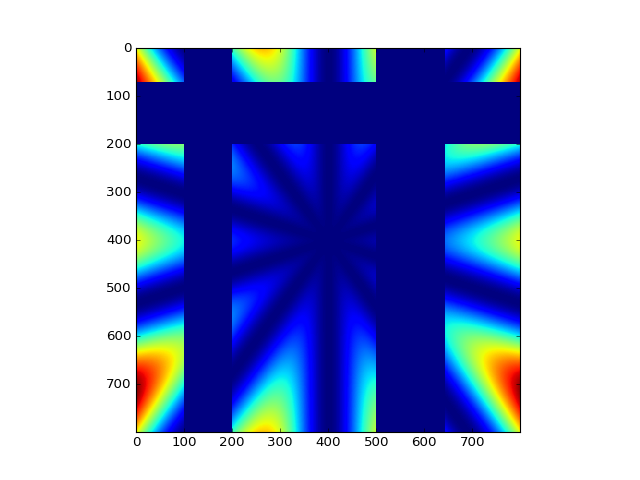

In [2]:
# first generate some random scattering pattern
# There are missing regions
from skbeam.core.utils import angle_grid, radial_grid
shape = 800,800
x0,y0 = 401, 401
ANGLES = angle_grid((y0, x0), shape)
RADII = radial_grid((y0, x0), shape)
img = np.cos(ANGLES*5)**2*RADII**2

mask = np.ones_like((ANGLES))
mask[100:200] = 0
mask[:,100:200] = 0
mask[:,500:643] = 0
mask[70:130] = 0

img*=mask

plt.figure(0);plt.clf();
plt.imshow(mask*img)



<IPython.core.display.Javascript object>


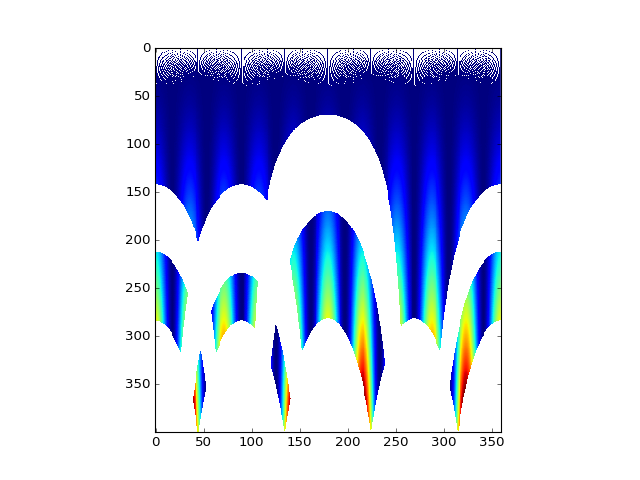

In [3]:
# reconstruct this into a polar grid
from skbeam.core.accumulators.binned_statistic import RPhiBinnedStatistic

rphibinstat = RPhiBinnedStatistic(shape, bins=(400,360), mask=mask, origin=(y0,x0))
rphi_img = rphibinstat(img)
plt.figure(2);plt.clf();
plt.imshow(rphi_img)

<IPython.core.display.Javascript object>


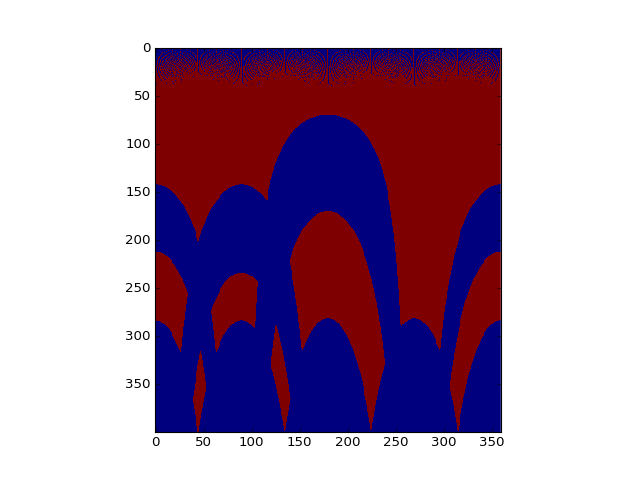

In [4]:
# create mask from np.nans since RPhiBinnedStatistic fills masked regions with np.nans
rphimask = np.ones_like(rphi_img)
rphimask[np.where(np.isnan(rphi_img))] = 0
plt.figure(3);plt.clf();
plt.imshow(rphimask)

In [5]:
# now regenerate the image to test construct_rphi_image

# test construction of rphi
angles = rphibinstat.bin_centers[1]
radii = rphibinstat.bin_centers[0]
#angles = np.logspace(-3, np.log10(2*np.pi),360)


# reprojection
Zproj = construct_rphi_avg_image(radii, angles, rphi_img, shape=(800,800))
#Zproj_masked = construct_rphi_avg_image(radii, angles, Z_masked, shape=(800,800),mask=mask)

# but we know we have 5 fold symmetry, so let's do something more interesting
# add the same image but before reconstructing, shift phi by 2pi/5....
Zproj_10fold = np.zeros_like(Zproj)
Zproj_10fold_mask = np.zeros_like(Zproj,dtype=int)
sym = int(10)
dphi = 2*np.pi/10.
for i in range(sym):
    anglesp = angles + dphi*i
    imgtmp = construct_rphi_avg_image(radii, anglesp, rphi_img, shape=(800,800))
    w = np.where(~np.isnan(imgtmp))
    Zproj_10fold[w] += imgtmp[w]
    Zproj_10fold_mask += (~np.isnan(imgtmp)).astype(int)
    
# the mask keeps count of included pixels. Average by this amount
Zproj_10fold /= Zproj_10fold_mask

/home/julienl/anaconda3/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


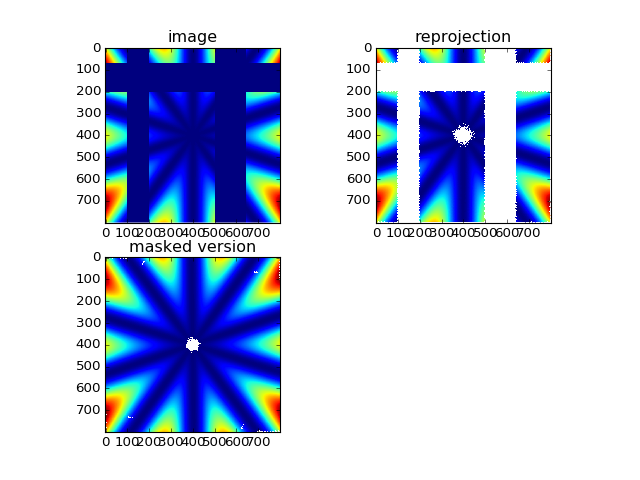

In [6]:
# And finally we have the reconstructed image assuming 5 fold symmetry
plt.figure(4);plt.clf()
plt.subplot(2,2,1).set_aspect("auto", adjustable="box");
plt.title("image")
plt.imshow(img)
plt.subplot(2,2,2).set_aspect("equal")
plt.title("reprojection")
plt.imshow(Zproj)
plt.subplot(2,2,3).set_aspect("auto", adjustable="box")
plt.title("masked version")
plt.imshow(Zproj_10fold)
#plt.subplot(2,2,4).set_aspect("equal")
#plt.title("mask aware reprojection")
#plt.imshow(Zproj_masked)